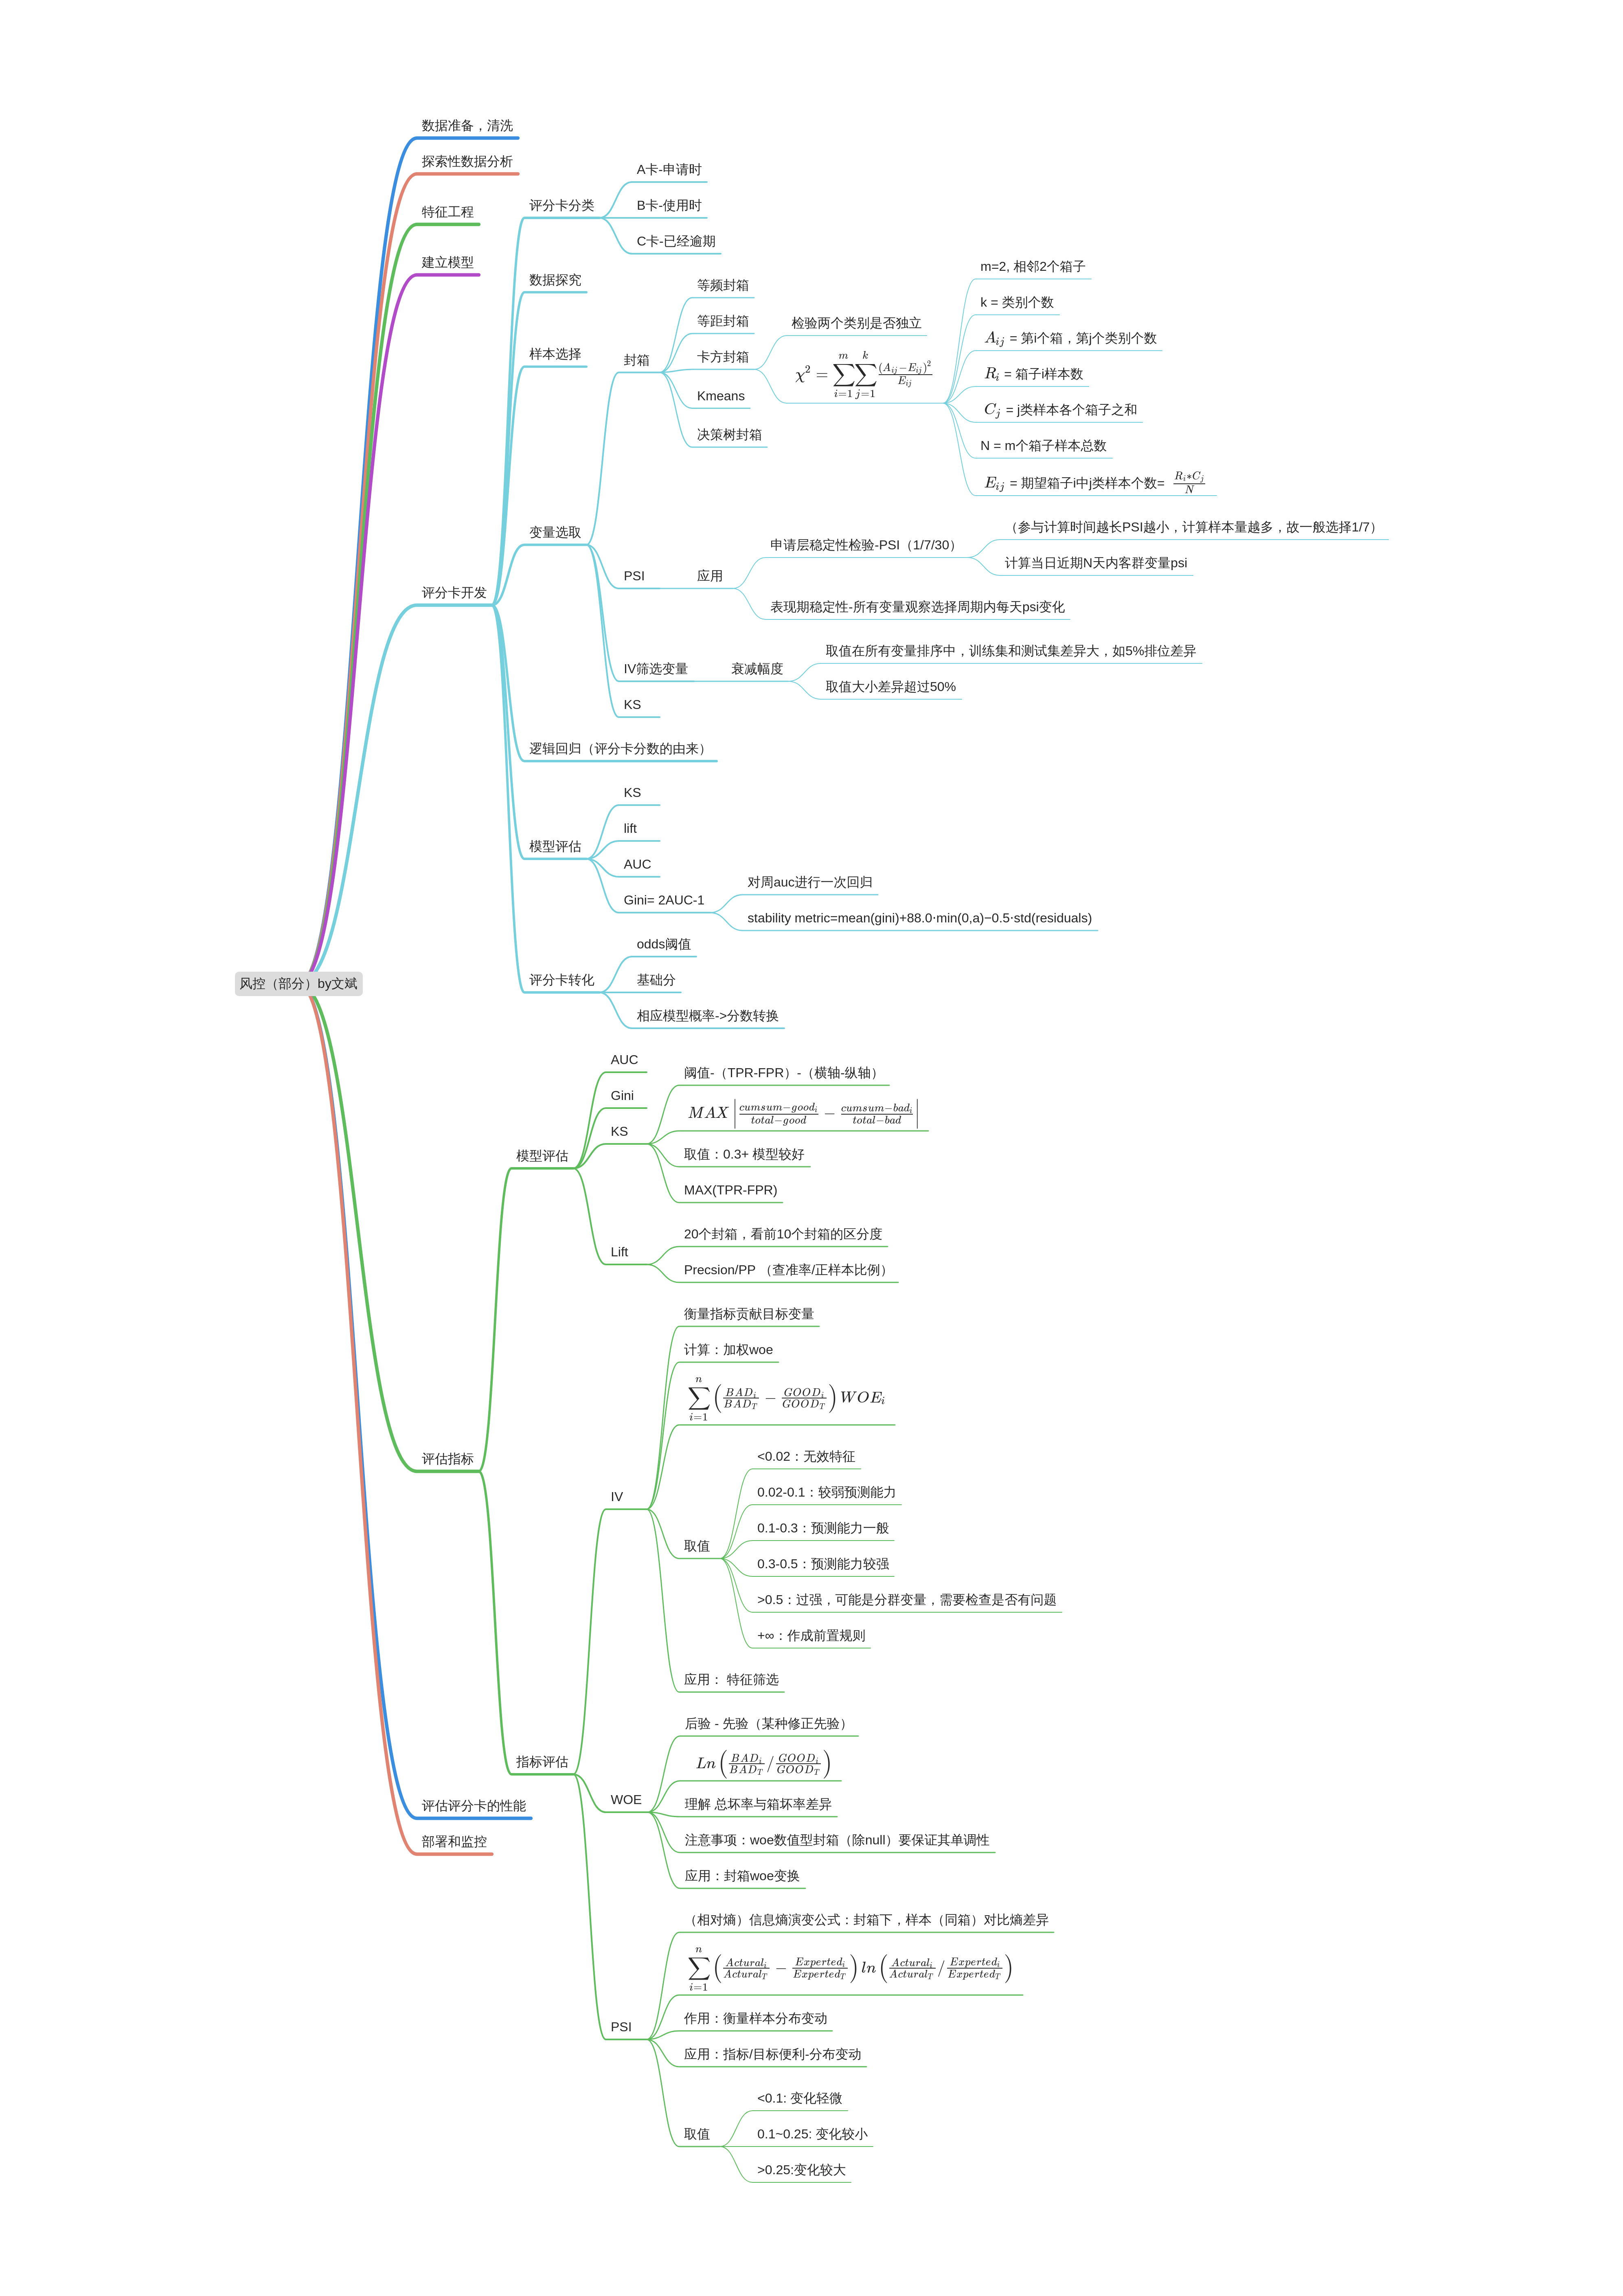

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# select numerical and categorical variables respectively.
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/creditrisk'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditrisk/testA.csv
/kaggle/input/creditrisk/train (1).csv
/kaggle/input/creditrisk/sample_submit.csv


In [3]:
# !pip install --upgrade scorecardbundle

### 拟通过一份金融风险数据，理解金融风控相关工作具体细节内容
数据来源[https://tianchi.aliyun.com/competition/entrance/531830/information].
这个份数据详情：该数据来自某信贷平台的贷款记录，总数据量超过120w，包含47列变量信息，其中15列为匿名变量。80万条作为训练集，20万条作为测试集A，20万条作为测试集B，同时对employmentTitle、purpose、postCode和title等信息进行脱敏。

#### <B>训练集数据字段详情

- id 为贷款清单分配的唯一信用证标识
- loanAmnt 贷款金额
- term 贷款期限（year）
- interestRate 贷款利率
- installment 分期付款金额
- grade 贷款等级
- subGrade 贷款等级之子级
- employmentTitle 就业职称
- employmentLength 就业年限（年）
- homeOwnership 借款人在登记时提供的房屋所有权状况
- annualIncome 年收入
- verificationStatus 验证状态
- issueDate 贷款发放的月份
- purpose 借款人在贷款申请时的贷款用途类别
- postCode 借款人在贷款申请中提供的邮政编码的前3位数字
- regionCode 地区编码
- dti 债务收入比
- delinquency_2years 借款人过去2年信用档案中逾期30天以上的违约事件数
- ficoRangeLow 借款人在贷款发放时的fico所属的下限范围
- ficoRangeHigh 借款人在贷款发放时的fico所属的上限范围
- openAcc 借款人信用档案中未结信用额度的数量
- pubRec 贬损公共记录的数量
- pubRecBankruptcies 公开记录清除的数量
- revolBal 信贷周转余额合计
- revolUtil 循环额度利用率，或借款人使用的相对于所有可用循环信贷的信贷金额
- totalAcc 借款人信用档案中当前的信用额度总数
- initialListStatus 贷款的初始列表状态
- applicationType 表明贷款是个人申请还是与两个共同借款人的联合申请
- earliesCreditLine 借款人最早报告的信用额度开立的月份
- title 借款人提供的贷款名称
- policyCode 公开可用的策略代码=1新产品不公开可用的策略代码=2
- n系列匿名特征 匿名特征n0-n14，为一些贷款人行为计数特征的处理

In [5]:
# =====================
# 读取金融数据
# =====================
train_df = pd.read_csv("/kaggle/input/creditrisk/train (1).csv")
test_df = pd.read_csv('/kaggle/input/creditrisk/testA.csv')

0.1995125


<Axes: >

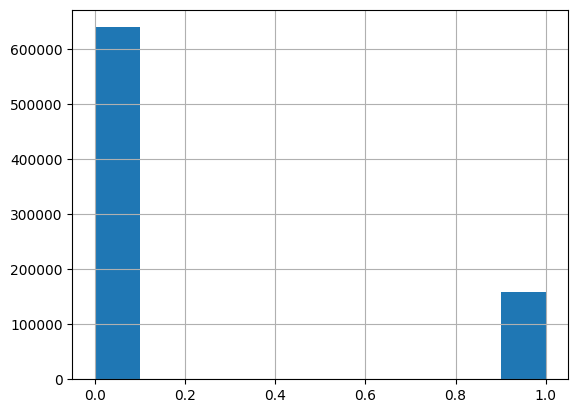

In [4]:
#=====================
# 风险人员比重
#=====================
print(train_df.isDefault.mean())
train_df.isDefault.hist()

In [6]:
# ========================
#  数据细节详情探查
# ========================

def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ
summ = summary(train_df)
summ

data shape: (800000, 47)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
id,int64,0,0.000000,800000,0.0,799999.0,0,1,2
loanAmnt,float64,0,0.000000,1540,500.0,40000.0,35000.0,18000.0,12000.0
term,int64,0,0.000000,2,3.0,5.0,5,5,5
interestRate,float64,0,0.000000,641,5.31,30.99,19.52,18.49,16.99
installment,float64,0,0.000000,72360,15.69,1715.42,917.97,461.9,298.17
grade,object,0,0.000000,7,NaN,NaN,E,D,D
subGrade,object,0,0.000000,35,NaN,NaN,E2,D2,D3
employmentTitle,float64,1,0.000125,248683,0.0,378351.0,320.0,219843.0,31698.0
employmentLength,object,46799,5.849875,11,NaN,NaN,2 years,5 years,8 years
homeOwnership,int64,0,0.000000,6,0.0,5.0,2,0,0


In [7]:


# ===================
# 字段列表
# id为索引，isDefault是
# 目标变量，而policyCode
# 只有一个取值，故而将
# 三者剔除
# issueDate，earliesCreditLine
# 两者是日期变量，暂时不考虑观察
# 
# 类别型：唯一值<=200 暂时认为是类别型
# ===================
cat_cols = summ[(summ['#unique']<=200) & (summ['#unique']>2)].index.values
summ[(summ['#unique']<=200) & (summ['#unique']>2)]

,data type,#missing,%missing,#unique,min,max,first value,second value,third value
grade,object,0,0.000000,7,NaN,NaN,E,D,D
subGrade,object,0,0.000000,35,NaN,NaN,E2,D2,D3
employmentLength,object,46799,5.849875,11,NaN,NaN,2 years,5 years,8 years
homeOwnership,int64,0,0.000000,6,0.0,5.0,2,0,0
verificationStatus,int64,0,0.000000,3,0.0,2.0,2,2,2
issueDate,object,0,0.000000,139,NaN,NaN,2014-07-01,2012-08-01,2015-10-01
purpose,int64,0,0.000000,14,0.0,13.0,1,0,0
regionCode,int64,0,0.000000,51,0.0,50.0,32,18,14
delinquency_2years,float64,0,0.000000,30,0.0,39.0,0.0,0.0,0.0
ficoRangeLow,float64,0,0.000000,39,630.0,845.0,730.0,700.0,675.0


In [8]:
colnamesdic = {
    'id' :'为贷款清单分配的唯一信用证标识',
    'loanAmnt' :'贷款金额',
    'term' :'贷款期限（year）',
    'interestRate' :'贷款利率',
    'installment' :'分期付款金额',
    'grade' :'贷款等级',
    'subGrade' :'贷款等级之子级',
    'employmentTitle' :'就业职称',
    'employmentLength' :'就业年限（年）',
    'homeOwnership' :'借款人在登记时提供的房屋所有权状况',
    'annualIncome' :'年收入',
    'verificationStatus' :'验证状态',
    'issueDate' :'贷款发放的月份',
    'purpose' :'借款人在贷款申请时的贷款用途类别',
    'postCode' :'借款人在贷款申请中提供的邮政编码的前3位数字',
    'regionCode' :'地区编码',
    'dti' :'债务收入比',
    'delinquency_2years' :'借款人过去2年信用档案中逾期30天以上的违约事件数',
    'ficoRangeLow' :'借款人在贷款发放时的fico所属的下限范围',
    'ficoRangeHigh' :'借款人在贷款发放时的fico所属的上限范围',
    'openAcc' :'借款人信用档案中未结信用额度的数量',
    'pubRec' :'贬损公共记录的数量',
    'pubRecBankruptcies' :'公开记录清除的数量',
    'revolBal' :'信贷周转余额合计',
    'revolUtil' :'循环额度利用率，或借款人使用的相对于所有可用循环信贷的信贷金额',
    'totalAcc' :'借款人信用档案中当前的信用额度总数',
    'initialListStatus' :'贷款的初始列表状态',
    'applicationType' :'表明贷款是个人申请还是与两个共同借款人的联合申请',
    'title' :'借款人提供的贷款名称',
    'earliesCreditLine': '借款人最早报告的信用额度开立的月份',
    'policyCode' :'公开可用的策略代码=1新产品不公开可用的策略代码=2'
}

for col in cat_cols:
    print("{} : {}".format(col, colnamesdic[col]))


    

grade : 贷款等级
subGrade : 贷款等级之子级
employmentLength : 就业年限（年）
homeOwnership : 借款人在登记时提供的房屋所有权状况
verificationStatus : 验证状态
issueDate : 贷款发放的月份
purpose : 借款人在贷款申请时的贷款用途类别
regionCode : 地区编码
delinquency_2years : 借款人过去2年信用档案中逾期30天以上的违约事件数
ficoRangeLow : 借款人在贷款发放时的fico所属的下限范围
ficoRangeHigh : 借款人在贷款发放时的fico所属的上限范围
openAcc : 借款人信用档案中未结信用额度的数量
pubRec : 贬损公共记录的数量
pubRecBankruptcies : 公开记录清除的数量
totalAcc : 借款人信用档案中当前的信用额度总数


KeyError: 'n0'

#### <B>基于名称，分以下有序和无序类别</B>

#### <B>无序</B>
- purpose : 借款人在贷款申请时的贷款用途类别
- regionCode : 地区编码
- homeOwnership : 借款人在登记时提供的房屋所有权状况
- n系列

#### <B>有序</B>
  -  grade : 贷款等级
  -  subGrade : 贷款等级之子级
  -  employmentLength : 就业年限（年）
  -  verificationStatus : 验证状态
  -  delinquency_2years : 借款人过去2年信用档案中逾期30天以上的违约事件数
  -  ficoRangeLow : 借款人在贷款发放时的fico所属的下限范围
  -  ficoRangeHigh : 借款人在贷款发放时的fico所属的上限范围
  -  openAcc : 借款人信用档案中未结信用额度的数量
  -  pubRec : 贬损公共记录的数量
  -  pubRecBankruptcies : 公开记录清除的数量
  -  totalAcc : 借款人信用档案中当前的信用额度总数

#### 日期数据
issueDate : 贷款发放的月份

In [9]:
import re

cat_ordered = ['grade','subGrade','employmentLength','verificationStatus','delinquency_2years',
               'ficoRangeLow','ficoRangeHigh','openAcc','pubRec','pubRecBankruptcies','totalAcc']
cat_disordered =  [col for col in train_df.columns if re.match(r'n\d+', col)] + ['purpose','regionCode','homeOwnership']

In [10]:
summ.loc[summ.index.isin(cat_ordered)]



,data type,#missing,%missing,#unique,min,max,first value,second value,third value
grade,object,0,0.000000,7,NaN,NaN,E,D,D
subGrade,object,0,0.000000,35,NaN,NaN,E2,D2,D3
employmentLength,object,46799,5.849875,11,NaN,NaN,2 years,5 years,8 years
verificationStatus,int64,0,0.000000,3,0.0,2.0,2,2,2
delinquency_2years,float64,0,0.000000,30,0.0,39.0,0.0,0.0,0.0
ficoRangeLow,float64,0,0.000000,39,630.0,845.0,730.0,700.0,675.0
ficoRangeHigh,float64,0,0.000000,39,634.0,850.0,734.0,704.0,679.0
openAcc,float64,0,0.000000,75,0.0,86.0,7.0,13.0,11.0
pubRec,float64,0,0.000000,32,0.0,86.0,0.0,0.0,0.0
pubRecBankruptcies,float64,405,0.050625,11,0.0,12.0,0.0,0.0,0.0


In [77]:
train_df.ficoRangeLow.value_counts()

ficoRangeLow
660.0    71974
670.0    69815
665.0    69619
675.0    61993
680.0    61294
685.0    53668
690.0    52046
695.0    47065
700.0    43292
705.0    39030
710.0    34296
715.0    30154
720.0    26036
725.0    20766
730.0    18186
735.0    14377
740.0    12585
745.0    10336
750.0     9419
755.0     8191
760.0     6716
765.0     6163
770.0     5311
775.0     4882
780.0     4286
785.0     3476
790.0     3284
795.0     2637
800.0     2261
805.0     1942
810.0     1408
815.0     1111
820.0      827
825.0      636
830.0      412
835.0      249
840.0      140
845.0      116
630.0        1
Name: count, dtype: int64

In [11]:
# ================
# 有序字符字段编码
# ================

# train_df[cat_ordered].head()
def encode_subgrad(subgrad):
    number = int(subgrad[1:])
    letter = ord(subgrad[0]) - ord('A') + 1
    return (letter - 1) * 5 + number - 1
def encode_grad(subgrad):
    return ord(subgrad[0]) - ord('A') 

train_df['grade'] = train_df['grade'].map( encode_grad )
train_df['subGrade'] = train_df['subGrade'].map( encode_subgrad )
test_df['grade'] = test_df['grade'].map( encode_grad )
test_df['subGrade'] = test_df['subGrade'].map( encode_subgrad )


In [12]:
# 提取数字部分的函数
def extract_years(value):
    if pd.isna(value):
        return None
    # 使用正则表达式匹配数字部分
    match = re.search(r'(\d+)', str(value))
    if match:
        return int(match.group(1))
    else:
        return None

# 提取数字部分并添加到 DataFrame 中
train_df['employmentLength'] = train_df['employmentLength'].apply(extract_years)
train_df['employmentLength'] = train_df['employmentLength'].fillna(-1)

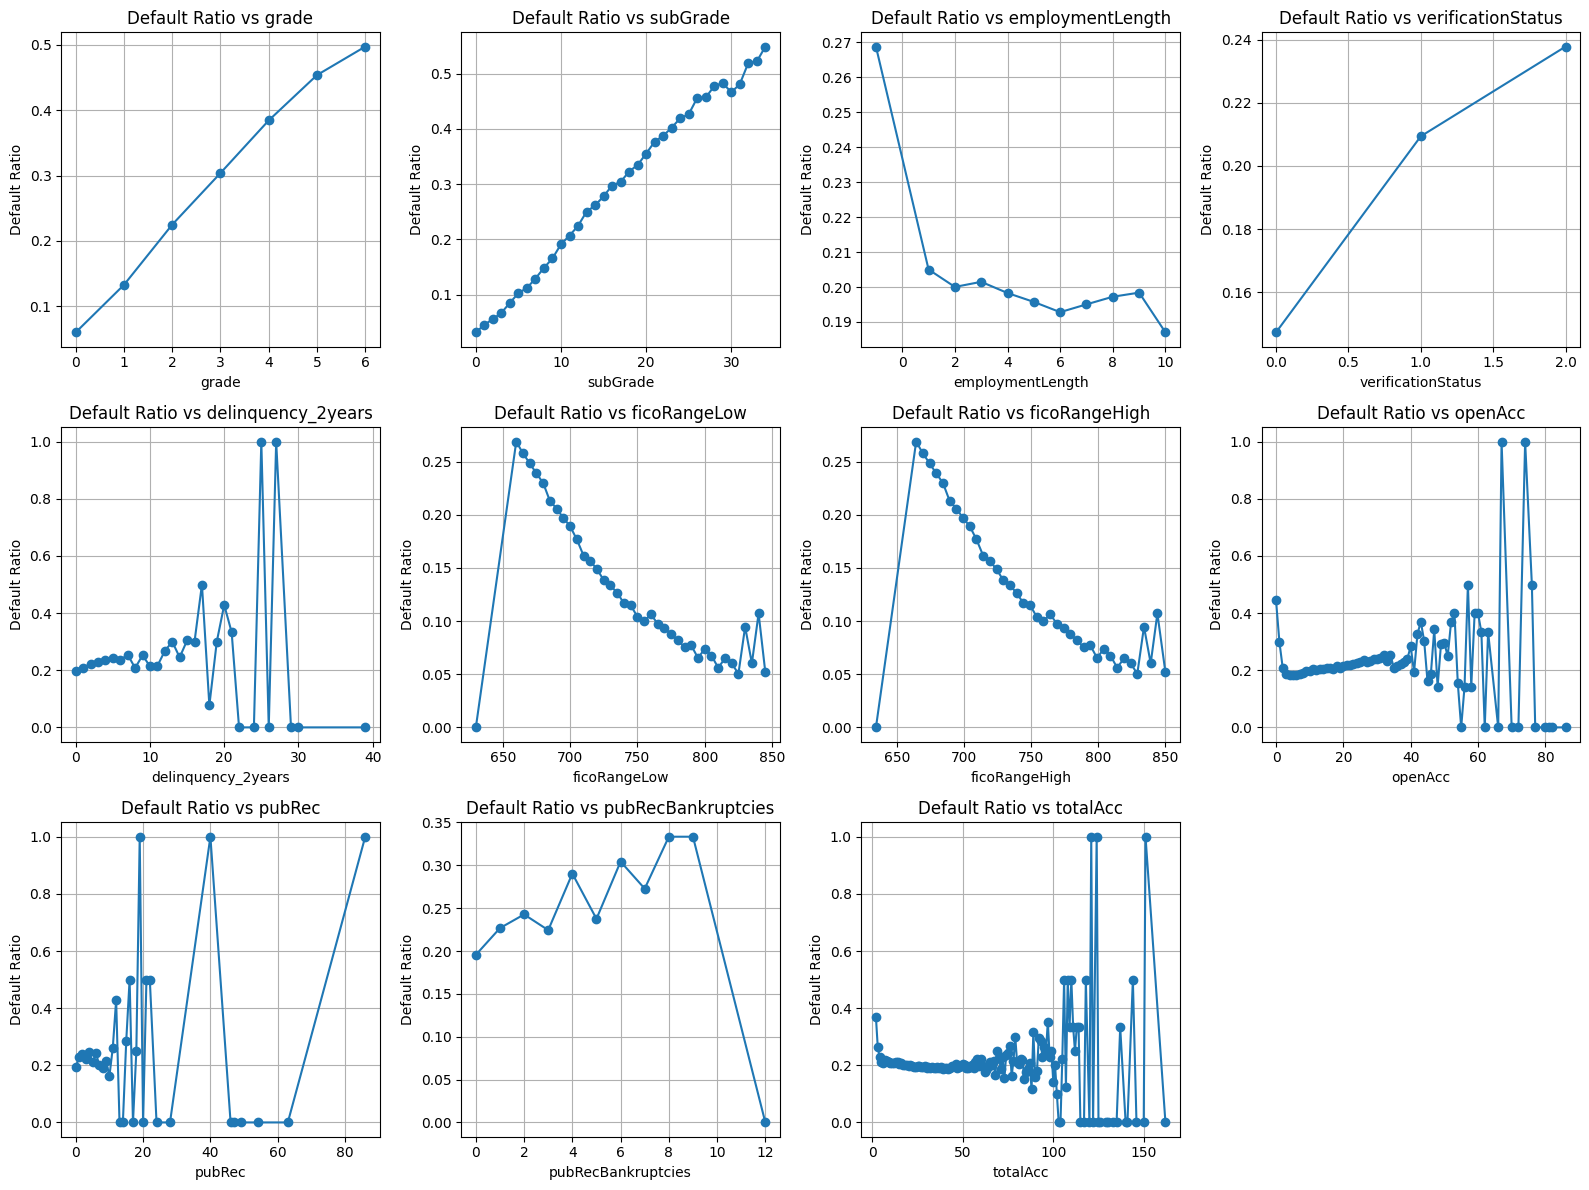

In [74]:
# ==================
# 变化关系图
# 有序类别变量-badrate
# ==================

num_plots = len(cat_ordered)
num_cols = 4
num_rows = (num_plots - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))

# 绘制子图
for i, field in enumerate(cat_ordered):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]

    # 计算每个字段对应的 default 比例
    field_default_ratio = train_df.groupby(field)['isDefault'].mean()

    # 绘制折线图
    ax.plot(field_default_ratio.index, field_default_ratio.values, marker='o')
    ax.set_xlabel(field)
    ax.set_ylabel('Default Ratio')
    ax.set_title('Default Ratio vs {}'.format(field))
    ax.grid(True)

# 删除未使用的子图
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# 调整子图布局
plt.tight_layout()
plt.show()

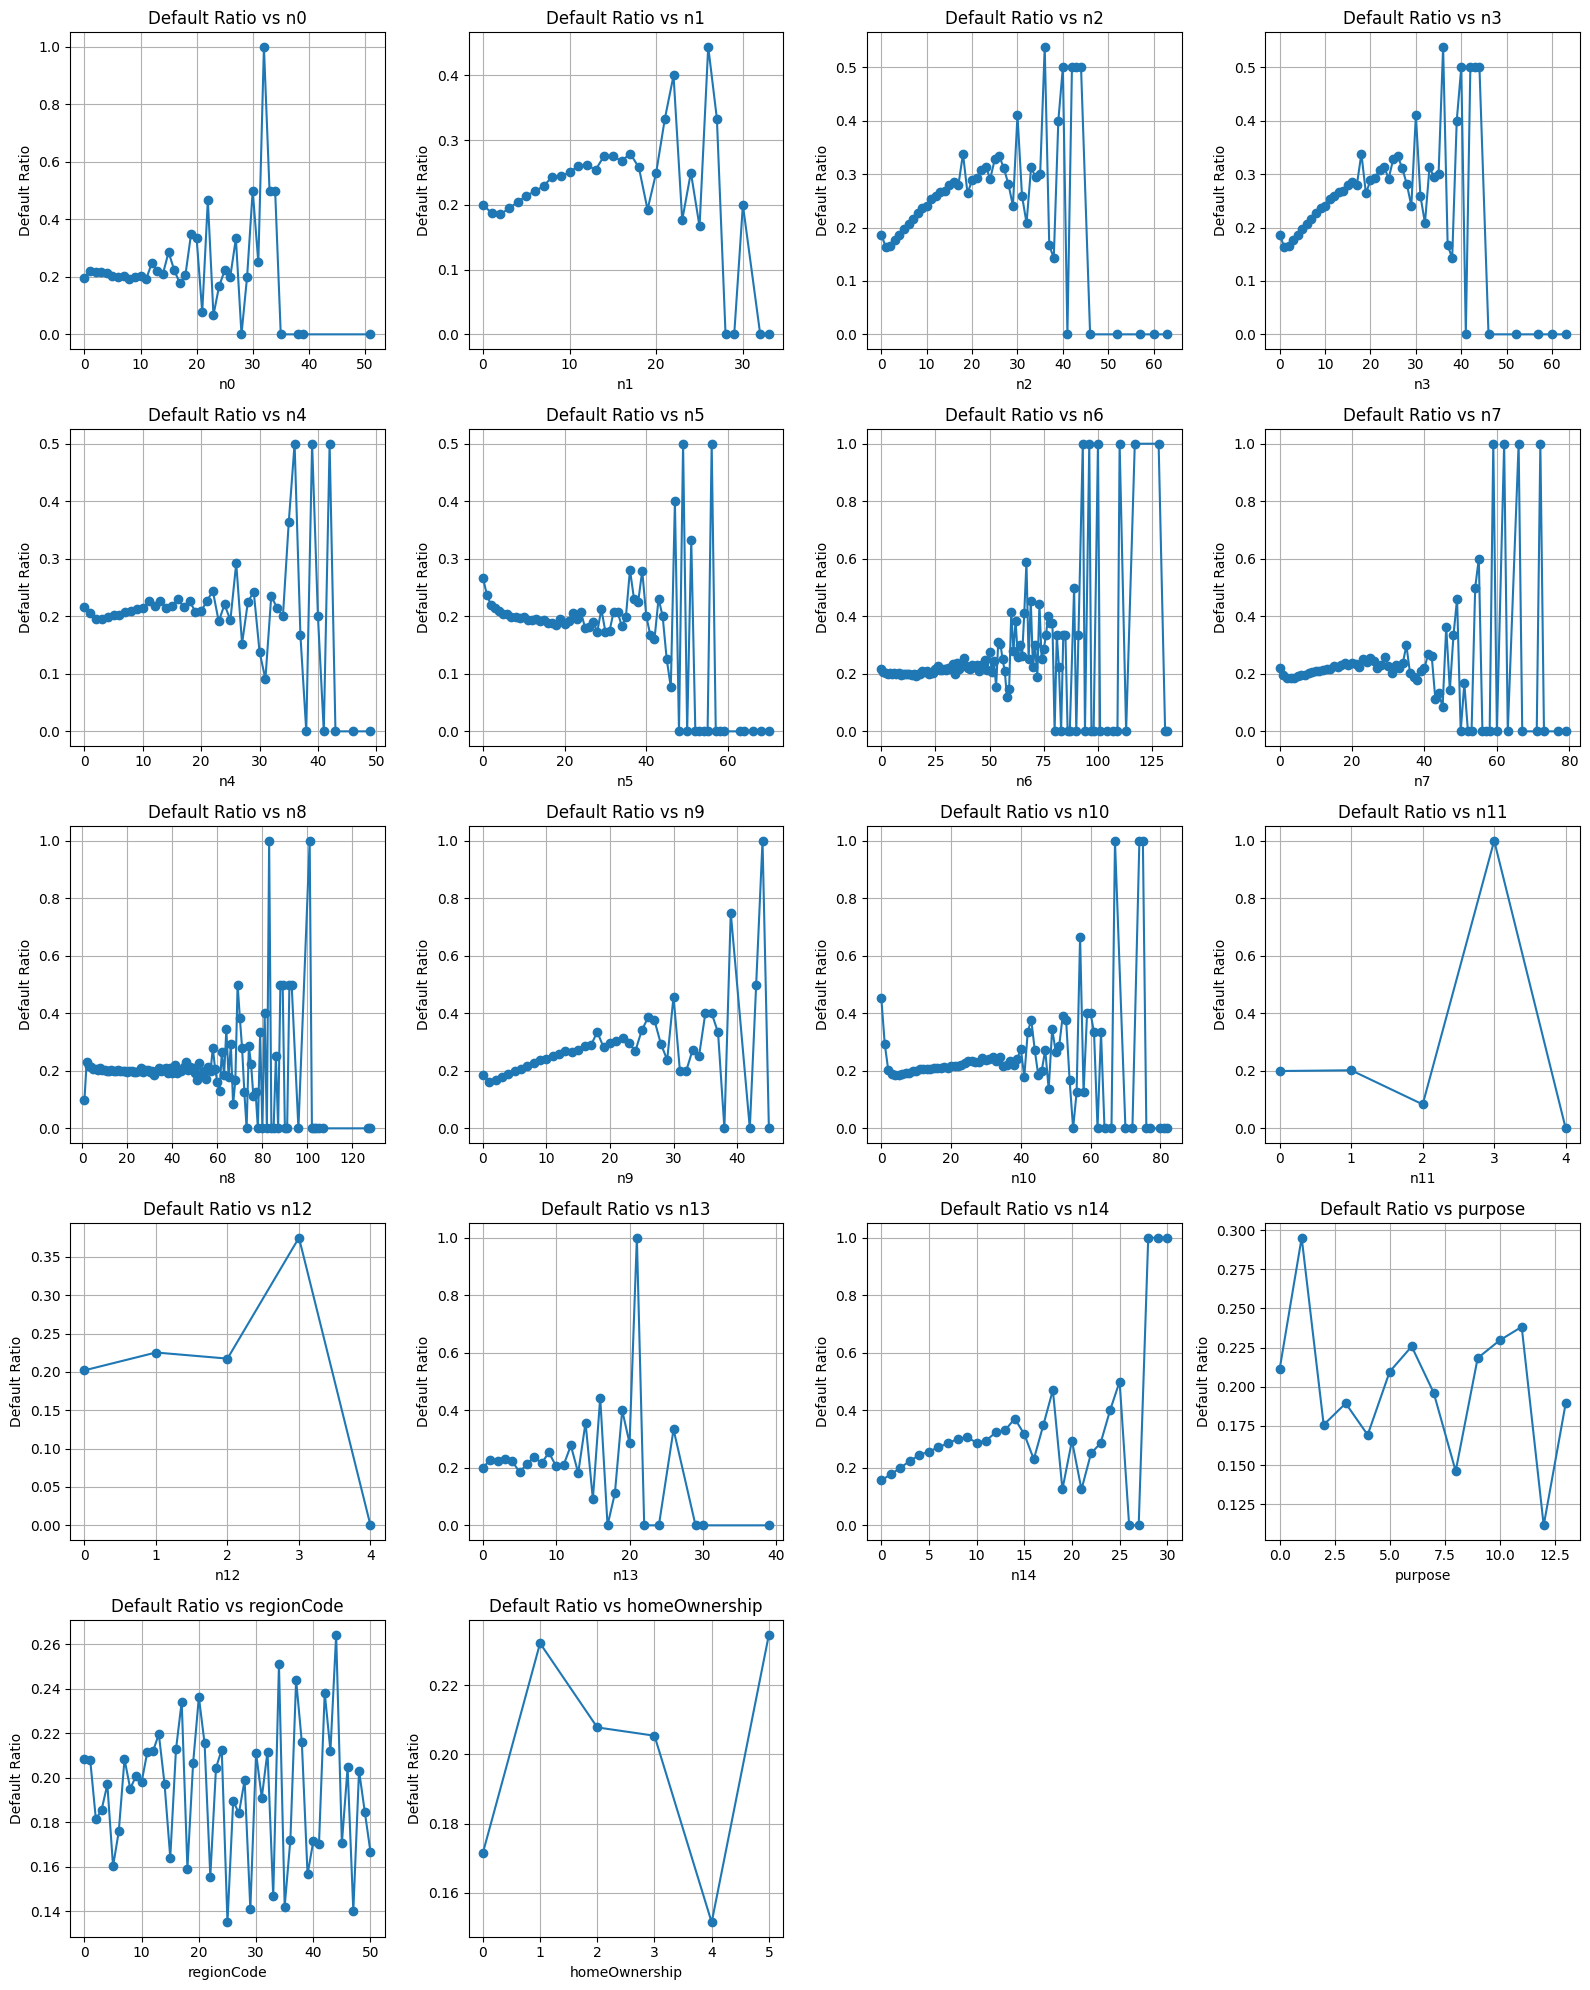

In [79]:
# ==================
# 变化关系图
# 无序类别变量-badrate
# ==================

# summ.loc[summ.index.isin(cat_disordered)]


num_plots = len(cat_disordered)
num_cols = 4
num_rows = (num_plots - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))

# 绘制子图
for i, field in enumerate(cat_disordered):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]

    # 计算每个字段对应的 default 比例
    field_default_ratio = train_df.groupby(field)['isDefault'].mean()

    # 绘制折线图
    ax.plot(field_default_ratio.index, field_default_ratio.values, marker='o')
    ax.set_xlabel(field)
    ax.set_ylabel('Default Ratio')
    ax.set_title('Default Ratio vs {}'.format(field))
    ax.grid(True)

# 删除未使用的子图
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# 调整子图布局
plt.tight_layout()
plt.show()

### 封箱-类别型


- 离散化程度高，且无序的变量：

      比如省份，职业等，我们会根据每个省份信息统计得到bad rate 数值对原始省份信息进行编码，这样就转化为了连续性变 量，进行后续的分箱操作，对于经过bad rate编码后的特征数据，天然单调。
只有当分箱后的所有的bin的bad rate 呈现单调性，才可以进行下一步的WOE编码

- 离散化程度低,且无序的变量：

        比如婚姻状况，只有四五个状态值，因此就不需要专门进行bad rate数值编码，只要求出每个离散值对应的bin的bad rate比例是否出现0或者1的情况，若出现说明正负样本的分布存在极端情况，需要对该bin与其他bin进行合并， 合并过程完了之后 就可以直接进行后续的WOE编码

- 有序的离散变量：

        对于学历这种情况，存在着小学，初中，高中，本科，硕士，博士等几种情况，而且从业务角度来说 这些离散值是有序的， 因此我们在分箱的时候，必须保证bin之间的有序性，再根据bad rate 是否为0 或者1的情况 决定是否进行合并，最终将合并的结果进行WOE编码

    因此bad rate单调性只在连续性数值变量和有序性离散变量分箱的过程中会考虑。


- 当类别数较少时,原则上不需要分箱
- 原则上，类别取值个数较多，使用badrate进行转化，然后进行封箱
- 否则， 检查最大箱，如果最大箱里面数据数量占总数据的90%以上，那么弃用这个变量
- 如果有特殊值，把特殊值单独分为一组，例如把-1单独分为一箱
- 当某个或者几个类别的bad rate为0时,需要和最小的非0bad rate的箱进行合并。
- 当该变量可以完全区分目标变量时,需要认真检查该变量的合理性。（可能是事后变量）

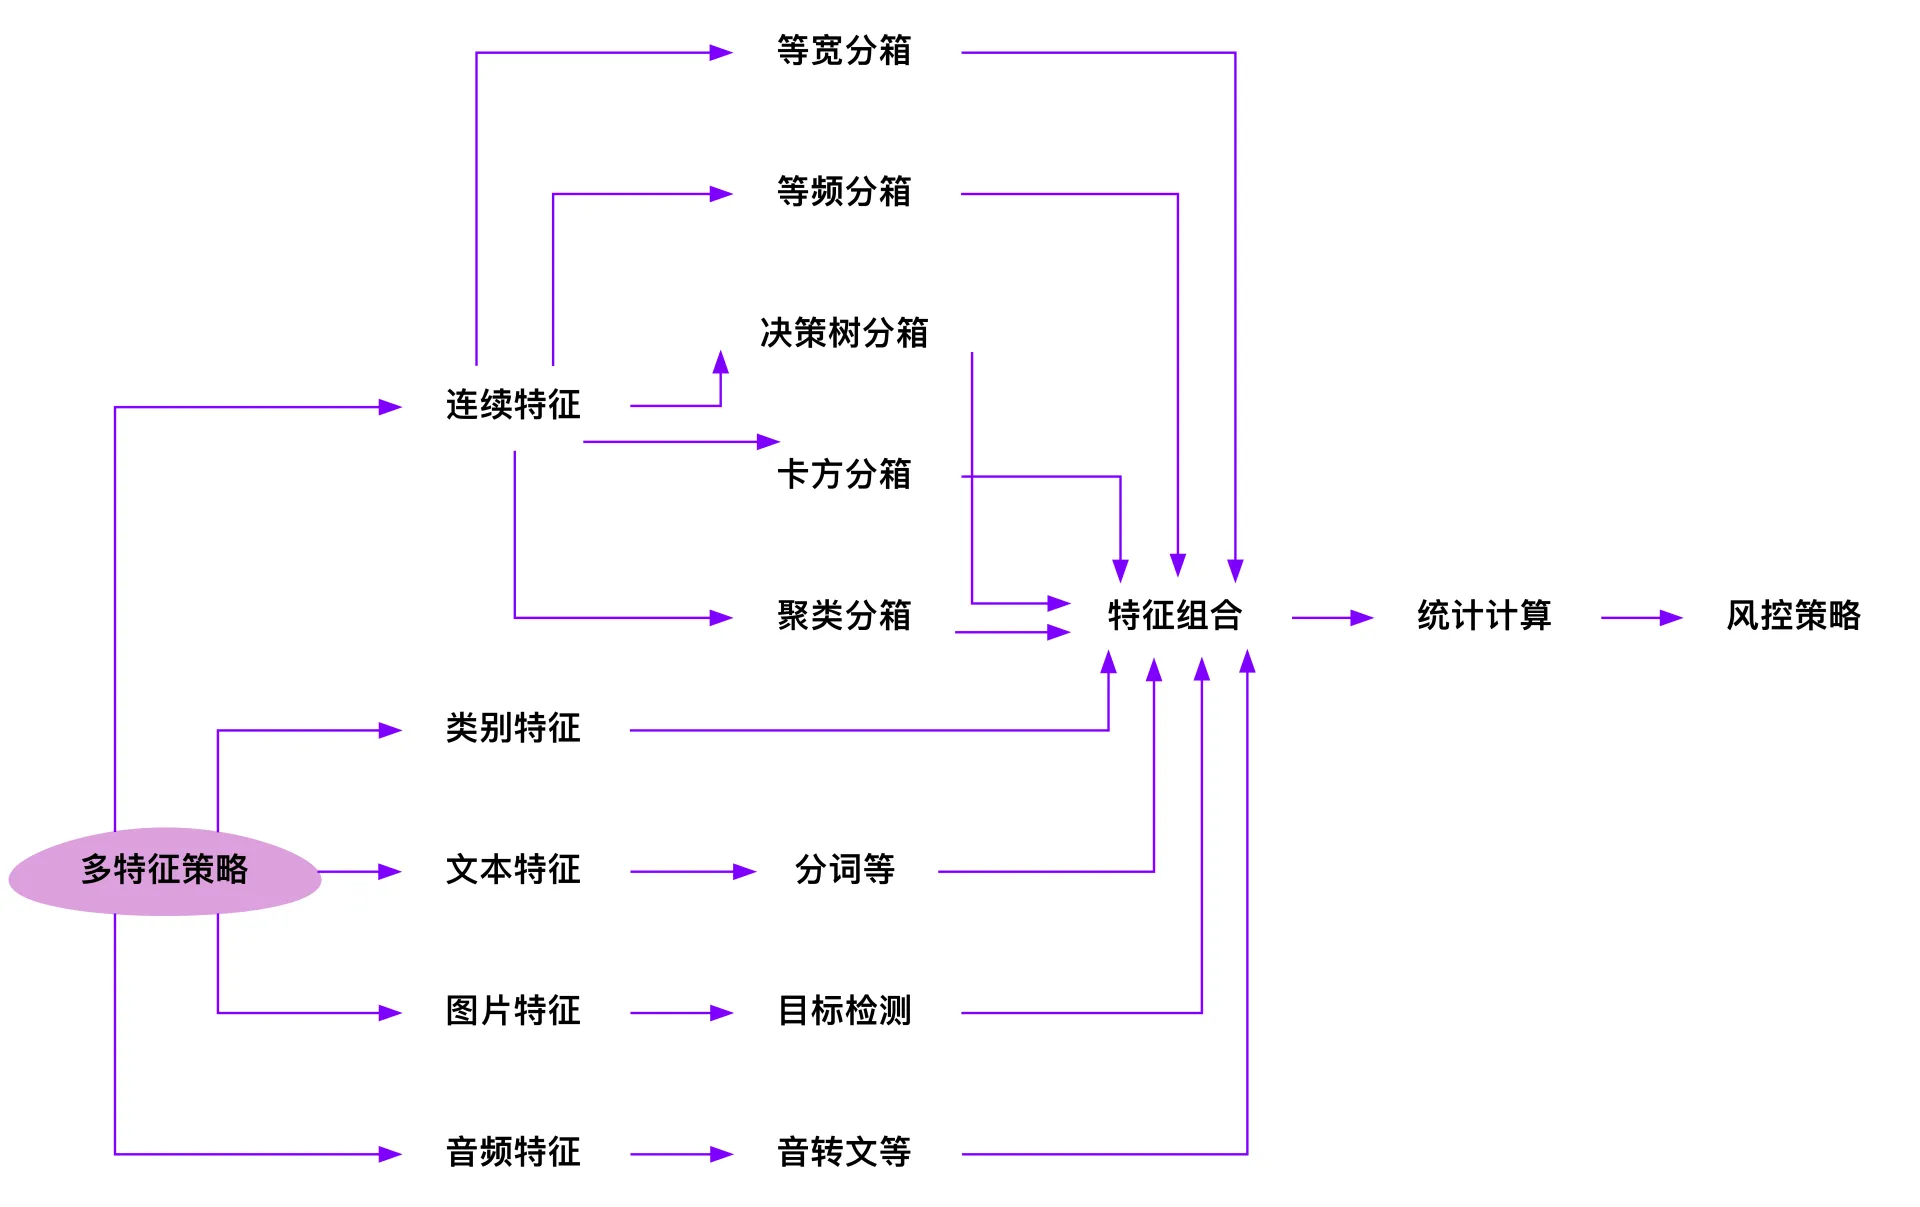

In [14]:
num_cols = summ[summ['#unique']>200].index.values
summ[summ['#unique']>200]

,data type,#missing,%missing,#unique,min,max,first value,second value,third value
id,int64,0,0.000000,800000,0.0,799999.0,0,1,2
loanAmnt,float64,0,0.000000,1540,500.0,40000.0,35000.0,18000.0,12000.0
interestRate,float64,0,0.000000,641,5.31,30.99,19.52,18.49,16.99
installment,float64,0,0.000000,72360,15.69,1715.42,917.97,461.9,298.17
employmentTitle,float64,1,0.000125,248683,0.0,378351.0,320.0,219843.0,31698.0
annualIncome,float64,0,0.000000,44926,0.0,10999200.0,110000.0,46000.0,74000.0
postCode,float64,1,0.000125,932,0.0,940.0,137.0,156.0,337.0
dti,float64,239,0.029875,6321,-1.0,999.0,17.05,27.83,22.77
revolBal,float64,0,0.000000,71116,0.0,2904836.0,24178.0,15096.0,4606.0
revolUtil,float64,531,0.066375,1286,0.0,892.3,48.9,38.9,51.8


In [15]:

for col in num_cols:
    print("{} : {}".format(col, colnamesdic[col]))


id : 为贷款清单分配的唯一信用证标识
loanAmnt : 贷款金额
interestRate : 贷款利率
installment : 分期付款金额
employmentTitle : 就业职称
annualIncome : 年收入
postCode : 借款人在贷款申请中提供的邮政编码的前3位数字
dti : 债务收入比
revolBal : 信贷周转余额合计
revolUtil : 循环额度利用率，或借款人使用的相对于所有可用循环信贷的信贷金额
earliesCreditLine : 借款人最早报告的信用额度开立的月份
title : 借款人提供的贷款名称


上述名称可以知道:
employmentTitle，earliesCreditLine，title,postCode为类别变量
数值变量于是为剔除这三个外，同时剔除id余下为数值型变量


In [16]:
num_cols = num_cols.tolist()
for col in ['id','employmentTitle','earliesCreditLine','title','postCode']:
    num_cols.remove(col)

In [17]:
summ.loc[summ.index.isin(num_cols)]

,data type,#missing,%missing,#unique,min,max,first value,second value,third value
loanAmnt,float64,0,0.000000,1540,500.0,40000.0,35000.0,18000.0,12000.0
interestRate,float64,0,0.000000,641,5.31,30.99,19.52,18.49,16.99
installment,float64,0,0.000000,72360,15.69,1715.42,917.97,461.9,298.17
annualIncome,float64,0,0.000000,44926,0.0,10999200.0,110000.0,46000.0,74000.0
dti,float64,239,0.029875,6321,-1.0,999.0,17.05,27.83,22.77
revolBal,float64,0,0.000000,71116,0.0,2904836.0,24178.0,15096.0,4606.0
revolUtil,float64,531,0.066375,1286,0.0,892.3,48.9,38.9,51.8


以上，分别区分出有序有序类别变量，多值少值类别变量，以及数值变量，下面对数据缺失值进行处理

In [18]:
# ==================
# 数值型变量缺失较少<5%
# 使用中位数填补
# ==================

train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())
test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].median())


In [19]:
# train_df[]
summ.loc[summ.index.isin(cat_cols)]

,data type,#missing,%missing,#unique,min,max,first value,second value,third value
grade,object,0,0.000000,7,NaN,NaN,E,D,D
subGrade,object,0,0.000000,35,NaN,NaN,E2,D2,D3
employmentLength,object,46799,5.849875,11,NaN,NaN,2 years,5 years,8 years
homeOwnership,int64,0,0.000000,6,0.0,5.0,2,0,0
verificationStatus,int64,0,0.000000,3,0.0,2.0,2,2,2
issueDate,object,0,0.000000,139,NaN,NaN,2014-07-01,2012-08-01,2015-10-01
purpose,int64,0,0.000000,14,0.0,13.0,1,0,0
regionCode,int64,0,0.000000,51,0.0,50.0,32,18,14
delinquency_2years,float64,0,0.000000,30,0.0,39.0,0.0,0.0,0.0
ficoRangeLow,float64,0,0.000000,39,630.0,845.0,730.0,700.0,675.0


In [12]:
# employmentTitle : 就业职称
#     earliesCreditLine : 借款人最早报告的信用额度开立的月份
#         title : 借款人提供的贷款名称
train_df['issueDate'].value_counts()

issueDate
2016-03-01    29066
2015-10-01    25525
2015-07-01    24496
2015-12-01    23245
2014-10-01    21461
              ...  
2007-08-01       23
2007-07-01       21
2008-09-01       19
2007-09-01        7
2007-06-01        1
Name: count, Length: 139, dtype: int64

In [38]:
# train_df[train_df['issueDate']=='2007-08-01'].isDefault.mean()
# train_df['year'] = train_df.issueDate.map(lambda x:x[:4])
yearPCT = train_df.groupby(['year'])['isDefault'].mean().values

In [39]:
(
#  计算标签为1的psi部分
    (  # P_actual_i(i=2007,2008...) - P_expect_i(2007,or2008,or...)
        yearPCT.reshape(1,-1) - yearPCT.reshape(-1,1)
    )*np.log(
        # P_actual_i(i=2007,2008...) / P_expect_i(2007,or2008,or...)
            yearPCT.reshape(1,-1) / yearPCT.reshape(-1,1)
    )
).sum(0)
+ (
    ((1-yearPCT).reshape(1,-1) - (1-yearPCT).reshape(-1,1))*np.log((1-yearPCT).reshape(1,-1) / (1-yearPCT).reshape(-1,1))
).sum(0)

array([0.01711473, 0.01819842, 0.04878067, 0.04049087, 0.02695786,
       0.0189072 , 0.02055876, 0.01863915, 0.02949722, 0.07185893,
       0.06812377, 0.01985471])

上述结果是基于某年为基础的违约分布变动情况，
- 例如基于2007违约分布计算其余年份对应情况获得psi为0.01711473
- 例如基于2008违约分布计算其余年份对应情况获得psi为0.01819842
- ...

相对来说发放贷款客群违约还是挺稳定的

In [14]:
# 

test_df['issueDate'].value_counts()

issueDate
2016-03-01    7476
2015-10-01    6393
2015-07-01    6094
2015-12-01    5721
2014-10-01    5307
              ... 
2008-09-01       5
2007-07-01       4
2007-09-01       4
2007-11-01       4
2007-08-01       4
Name: count, Length: 138, dtype: int64

#### 数值型变量 逾期/正常 样本分布情况

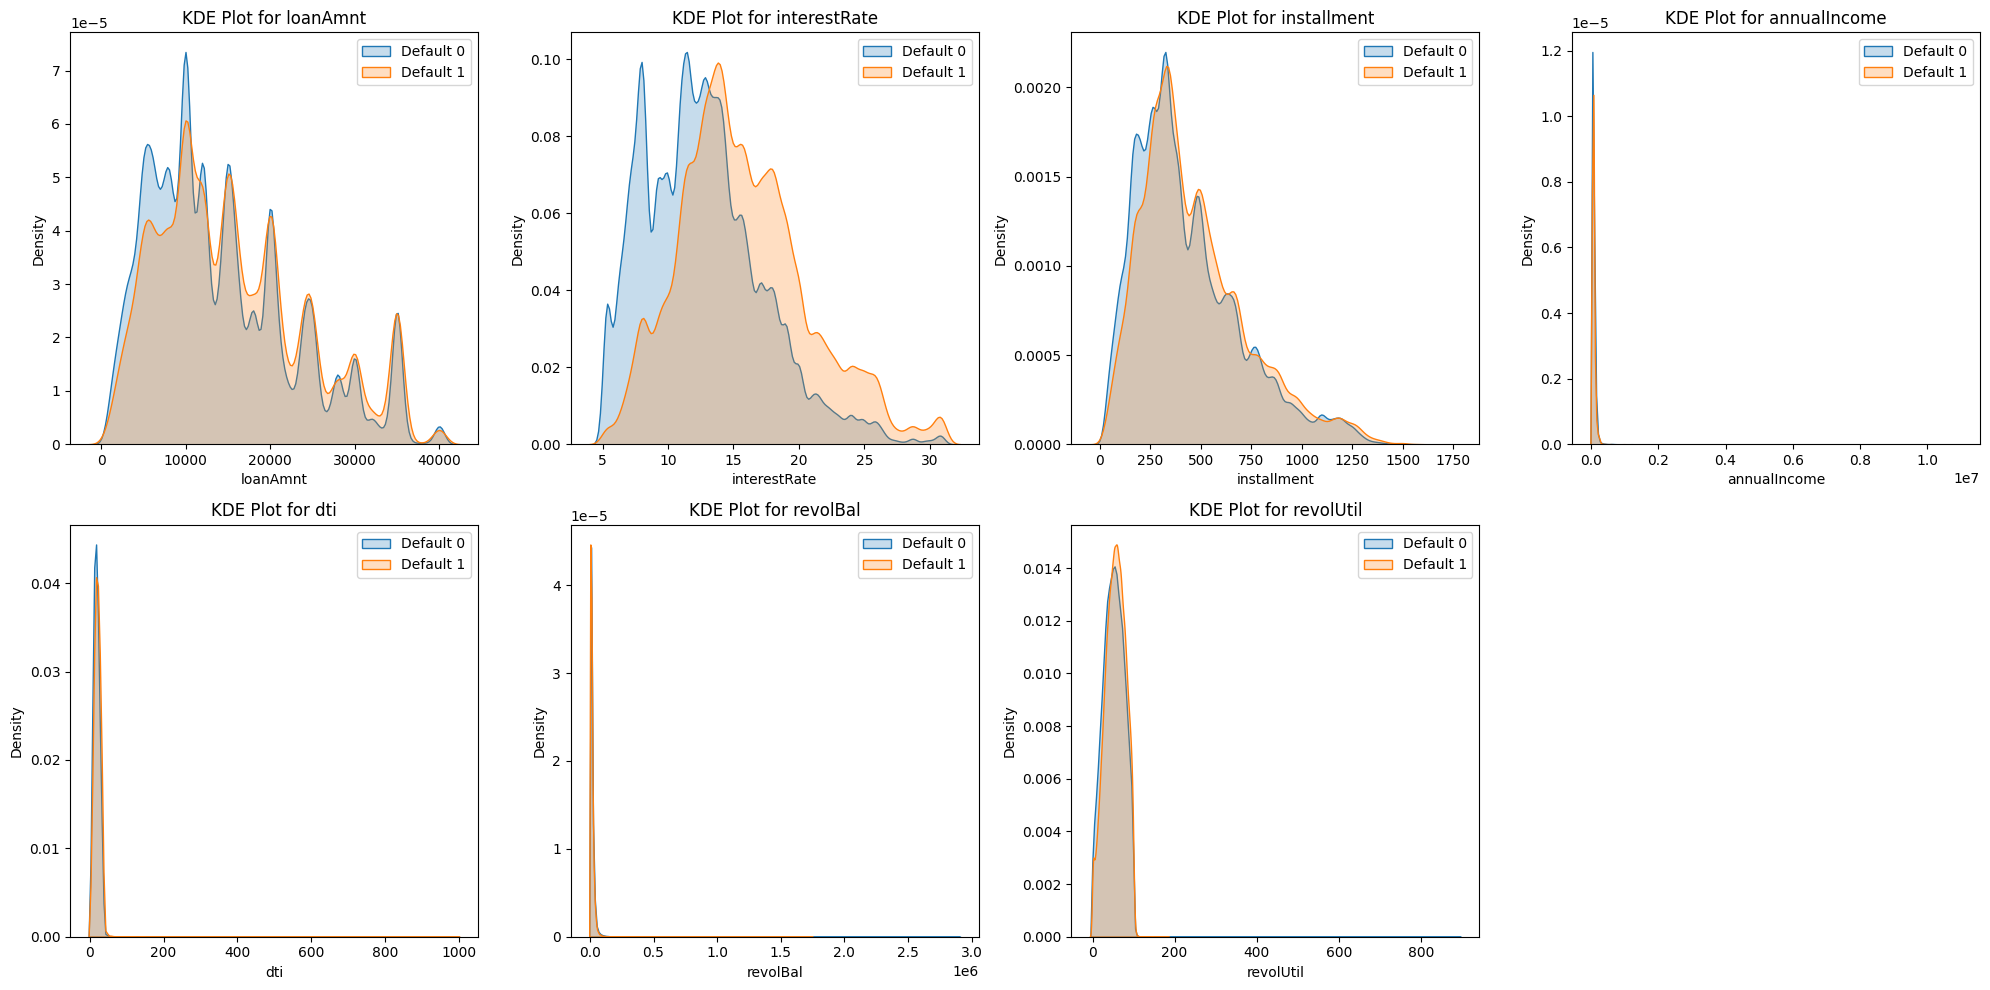

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 示例数据（假设 df 是包含多个数值型变量和 target 变量的 DataFrame）
# df = ...

# 计算行数和列数
numcols = 4
numvars = len(num_cols)
numrows = -(-numvars // numcols)  # 向上取整

# 创建子图
fig, axes = plt.subplots(numrows, numcols, figsize=(5*numcols, 5*numrows))

# 绘制每个数值型变量的 KDE 图
for i, col in enumerate(num_cols):
    row_idx = i // numcols
    col_idx = i % numcols
    sns.kdeplot(train_df.loc[train_df['isDefault'] == 0, col], label='Default 0', shade=True, ax=axes[row_idx, col_idx])
    sns.kdeplot(train_df.loc[train_df['isDefault'] == 1, col], label='Default 1', shade=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title('KDE Plot for {}'.format(col))
    axes[row_idx, col_idx].set_xlabel(col)
    axes[row_idx, col_idx].set_ylabel('Density')
    axes[row_idx, col_idx].legend()

# 删除多余的子图
for i in range(numvars, numrows*numcols):
    row_idx = i // numcols
    col_idx = i % numcols
    fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()


图表分布可以看出,1到3个变量区分能力较强，其余的较为一般。我们对这些变量进行<B>简单等距分箱</B>然后观察IV值看看是否如此。

In [50]:
import pandas as pd
import numpy as np

def calculate_woe_iv(df, col, target):
    # 计算列联表
    crosstab_result = pd.crosstab(df[col], df[target])
    crosstab_result.columns = ['negative', 'positive']
    
    # 计算总的坏样本数和好样本数
    total_bad = crosstab_result['positive'].sum()
    total_good = crosstab_result['negative'].sum()
    
    # 计算每个分箱的WOE值和IV值
    crosstab_result['woe'] = np.log((crosstab_result['positive'] / total_bad) / (crosstab_result['negative'] / total_good))
    crosstab_result['iv'] = (crosstab_result['positive'] / total_bad - crosstab_result['negative'] / total_good) * crosstab_result['woe']
    
    # 计算总的IV值
    iv = crosstab_result['iv'].sum()
    
    return crosstab_result, iv



def quick_IV(data,cols,target):
    df = data[cols+[target]].copy()
    woe_iv_result = pd.DataFrame(columns=['colname', 'woe', 'iv'])
    for col in cols:
#         df[col] = pd.cut(df[col], bins=5, include_lowest=True)
        df[col] = pd.qcut(df[col], q = 5, labels = ['E','D','C', 'B', 'A'])
        crosstab_result, iv = calculate_woe_iv(df, col, target)
        print("{}:iv:{}".format(col,iv))
        woe_iv_result = pd.concat([woe_iv_result, pd.DataFrame({'colname': [col]*len(crosstab_result), 'woe': crosstab_result['woe'], 'iv': iv})], ignore_index=True)
#         woe_iv_result = woe_iv_result.append({'colname': col, 'woe': crosstab_result['woe'], 'iv': iv}, ignore_index=True)
    return woe_iv_result
target = 'isDefault'
woe_iv = quick_IV(train_df,num_cols,target)

loanAmnt:iv:0.03337150418668226
interestRate:iv:0.422987169030105
installment:iv:0.028452293903408848
annualIncome:iv:0.028083848322733147
dti:iv:0.06801561645483563
revolBal:iv:0.0027509813157816157
revolUtil:iv:0.023026431936125837


In [52]:
# train_df['annualIncome'].isnull().sum()
woe_iv[woe_iv.colname=='loanAmnt']

,colname,woe,iv
0,loanAmnt,-0.284426,0.033372
1,loanAmnt,-0.152051,0.033372
2,loanAmnt,0.052078,0.033372
3,loanAmnt,0.163393,0.033372
4,loanAmnt,0.197802,0.033372


##### 对比toad包与自定义函数计算结果是否一致

In [53]:
# woe_iv
!pip install toad
import toad  
iv_info = toad.quality(train_df,'isDefault', iv_only=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 20.0 MB/s eta 0:00:0000:0100:01


In [56]:
col = 'interestRate'
df = train_df[[col,target]].copy()
df[col] = pd.qcut(df[col], q = 5, labels = ['E','D','C', 'B', 'A'])
iv_info = toad.quality(df,'isDefault', iv_only=True)

In [57]:
iv_info

,iv,gini,entropy,unique
interestRate,0.422987,NaN,NaN,5.0


##### 上述自定义与toad包计算iv结果是一致的，这里尝试优化分箱-使用chimerge

In [59]:
from scorecardbundle.feature_discretization.ChiMerge import ChiMerge
chimerge = ChiMerge(confidence_level=0.9, max_intervals=20)
X = train_df[num_cols]
Y = train_df[target]
chimerge.fit(X,Y)

ChiMerge(max_intervals=20)

In [60]:
res = chimerge.transform(X)


In [87]:
observed

isDefault,0,1
interestRate,,
"(-inf, 17.57]",554460,109551
"(17.57, 17.86]",5907,2618
"(17.86, 18.25]",12548,6007
"(18.25, 18.99]",13062,6422
"(18.99, 19.48]",6397,3107
"(19.48, 20.0]",10314,5881
"(20.0, 21.48]",10340,5584
"(21.48, 22.99]",10109,6547
"(22.99, 24.99]",9068,6465


[0.16498371261921865,
 0.30709677419354836,
 0.3237402317434654,
 0.32960377745842745,
 0.3269149831649832,
 0.3631367706082124,
 0.3506656618939965,
 0.39307156580211333,
 0.41621064829717375,
 0.4757573816691219]

In [95]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

def calculate_chi_square(observed, expected):
    return (observed - expected)**2 / expected

def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))

def monotonic(L):
    return non_decreasing(L) or non_increasing(L)

def check_bad_rate_monotonicity(data, target, intervals):
    print("="*35)
    itv = [-np.inf]+[i[1] for i in intervals[:-1]]+[np.inf]
    observed = pd.crosstab(pd.cut(data, bins=itv, include_lowest=True), target)
    bad_rates = list(observed[1]/(observed[1]+observed[0]).values)
    
    for interval,bad_rate in zip(intervals,bad_rates):
        print("INTER:{} BADRATE:{}".format(interval, bad_rate))
    print("="*35)
    return monotonic(bad_rates)

def chi_merge(data, target, feature,int_intervals ,max_intervals=5, confidence_level=0.05):
    # 初始化分箱
    quantiles = np.quantile(data[feature], np.linspace(0, 1, int_intervals+1))
    intervals = [[quantiles[i], quantiles[i+1]] for i in range(len(quantiles)-1)]
    
    while len(intervals) > max_intervals:
        # 计算相邻分箱的卡方值
        chi_squares = []
        for i in range(len(intervals)-1):
            interval1 = intervals[i]
            interval2 = intervals[i+1]
            
            observed = pd.crosstab(pd.cut(data[feature], bins=[interval1[0],interval1[1], interval2[1]], include_lowest=True), data[target])
            expected = pd.DataFrame(np.outer(observed.sum(axis=1), observed.sum(axis=0)) / observed.values.sum(), index=observed.index, columns=observed.columns)
            
            chi_square = calculate_chi_square(observed.values, expected.values)
            chi_squares.append(chi_square.sum())
        
        # 找到最小的卡方值
        min_chi_square_index = np.argmin(chi_squares)
        min_chi_square = chi_squares[min_chi_square_index]
        
        # 计算临界值
        critical_value = chi2.ppf(1 - confidence_level, df=1)
        
        # 检查bad rate单调性
        is_mot =  check_bad_rate_monotonicity(data[feature], data[target], intervals)
        # 合并卡方值小于临界值的相邻分箱
        if (min_chi_square < critical_value
            or not is_mot):
            merged_interval = [intervals[min_chi_square_index][0], intervals[min_chi_square_index+1][1]]
            print("DEL:{}".format(intervals[min_chi_square_index:min_chi_square_index+2]))
            print("INSERT:{}".format( merged_interval ))
            del intervals[min_chi_square_index:min_chi_square_index+2]
            intervals.insert(min_chi_square_index, merged_interval)
        else:
            break
    
    return intervals

30.99

In [96]:
col = 'interestRate'
df = train_df[[col,target]].copy()
chi_merge(df, target, col, int_intervals=50,max_intervals=10, confidence_level=0.05)

INTER:[5.31, 5.32] BADRATE:0.03434159654309757
INTER:[5.32, 6.24] BADRATE:0.03316616516215313
INTER:[6.24, 6.89] BADRATE:0.04836258842022531
INTER:[6.89, 7.12] BADRATE:0.05792215752375115
INTER:[7.12, 7.39] BADRATE:0.07168208898466219
INTER:[7.39, 7.89] BADRATE:0.07319900446626436
INTER:[7.89, 7.9] BADRATE:0.06318589956767542
INTER:[7.9, 8.18] BADRATE:0.09502060822100925
INTER:[8.18, 8.39] BADRATE:0.10543471030399787
INTER:[8.39, 8.9] BADRATE:0.08639412328329607
INTER:[8.9, 9.17] BADRATE:0.11257200650806913
INTER:[9.17, 9.49] BADRATE:0.11705202312138728
INTER:[9.49, 9.93] BADRATE:0.12188956917373477
INTER:[9.93, 10.15] BADRATE:0.11402629931120851
INTER:[10.15, 10.49] BADRATE:0.13625457759818158
INTER:[10.49, 10.91] BADRATE:0.15759162303664923
INTER:[10.91, 10.99] BADRATE:0.13738938053097347
INTER:[10.99, 11.39] BADRATE:0.12009930692045102
INTER:[11.39, 11.49] BADRATE:0.18175748977718434
INTER:[11.49, 11.53] BADRATE:0.15595602402810835
INTER:[11.53, 11.99] BADRATE:0.15728955741972808
IN

[[5.31, 6.24],
 [6.24, 7.12],
 [7.12, 7.9],
 [7.9, 8.9],
 [8.9, 10.15],
 [10.15, 11.39],
 [11.39, 12.62],
 [12.62, 13.18],
 [13.18, 13.98],
 [13.98, 15.8],
 [15.8, 16.2],
 [16.2, 17.86],
 [17.86, 21.48],
 [21.48, 24.99],
 [24.99, 30.99]]

In [99]:
col = 'interestRate'
itv = [-np.inf]+[i[1] for i in intervals[:-1]]+[np.inf]
df['chi_'+col] =  pd.cut(df[col], bins=itv, include_lowest=True)

crosstab_result, iv = calculate_woe_iv(df, 'chi_'+col, target)
print('新iv：{} 旧iv:0.422987169030105'.format(iv))
#结论： 优化分箱可以提升区分能力

新iv：0.46517329482282477 旧iv:0.422987169030105


In [19]:
# !pip install toad
def calculate_psi(actual, expected, bins=10):
    """Calculate Population Stability Index (PSI)"""
    actual_pct = pd.cut(actual, bins=bins, include_lowest=True).value_counts(normalize=True)
    expected_pct = pd.cut(expected, bins=bins, include_lowest=True).value_counts(normalize=True)
    psi = sum((actual_pct - expected_pct) * np.log(actual_pct / expected_pct))
    return psi